# Step #1 Load the Data

In [2]:
# Time Series Forecasting - Regression for Daily hospital visits prediction

import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.11.0
Num GPUs: 1


In [3]:
path_csv = '/content/city_dataset_1.csv'

In [4]:
df = pd.read_csv(path_csv)
df['target_d1'] = (df['D1A1'] + df['D1A2'] + df['D1A3'] + df['D1A4'])*100
df['target_d2'] = (df['D2A1'] + df['D2A2'] + df['D2A3'] + df['D2A4'])*100
df = df.drop(['day_num', 'date', 'Age1', 'Age2', 'Age3', 'Age4', 'literate',
              'vegetation', 'D1A1', 'D1A2', 'D1A3', 'D1A4', 'D2A1', 'D2A2', 
              'D2A3', 'D2A4'], axis=1)

start_date = '2015-03-21'
end_date =  '2019-09-22'
df['date'] = pd.date_range(start_date, end_date)
df.set_index('date', inplace=True)
df.head()

,temprture,relh,wind_sped,Ave24hO3,Ave24hNO,Ave24hNO2_ppb,Ave24hNOx,Ave24hPM10,Ave24hSO2_ppb,Ave24hCO,Ave24h PM2.5,target_d1,target_d2
date,,,,,,,,,,,,,
2015-03-21,0.422193,0.705090,0.204558,0.215088,0.052561,0.254035,0.120980,0.094944,0.116997,0.298165,0.042088,13.0,12.0
2015-03-22,0.297337,0.784966,0.583254,0.206259,0.034000,0.150526,0.073354,0.018406,0.045770,0.211482,0.032855,3.0,16.0
2015-03-23,0.252944,0.545862,0.141443,0.225935,0.073821,0.430877,0.198740,0.113383,0.117710,0.348533,0.050736,4.0,14.0
2015-03-24,0.279996,0.499940,0.174661,0.213827,0.221294,0.392982,0.291659,0.079880,0.029606,0.390849,0.036994,3.0,18.0
2015-03-25,0.336875,0.566606,0.201237,0.145018,0.267021,0.715088,0.435217,0.060196,0.060307,0.516847,0.008432,7.0,11.0


In [5]:
df.columns

Index(['temprture', 'relh', 'wind_sped', 'Ave24hO3', 'Ave24hNO',
       'Ave24hNO2_ppb', 'Ave24hNOx', 'Ave24hPM10', 'Ave24hSO2_ppb', 'Ave24hCO',
       'Ave24h PM2.5', 'target_d1', 'target_d2'],
      dtype='object')

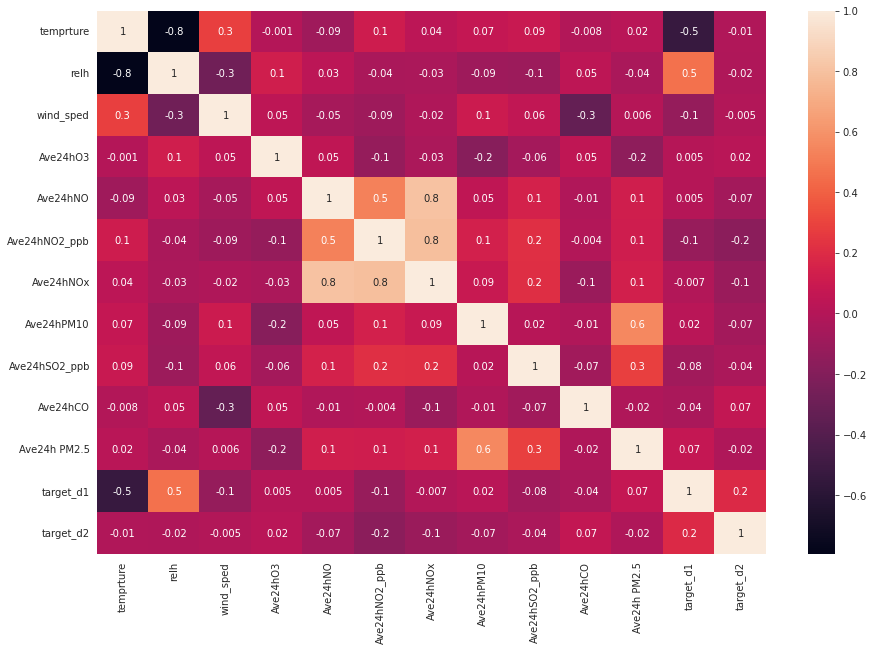

In [6]:
correlation = df.corr()
fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(correlation, annot=True, fmt=".1g")
plt.show()

# Step #2 Exploring the Data

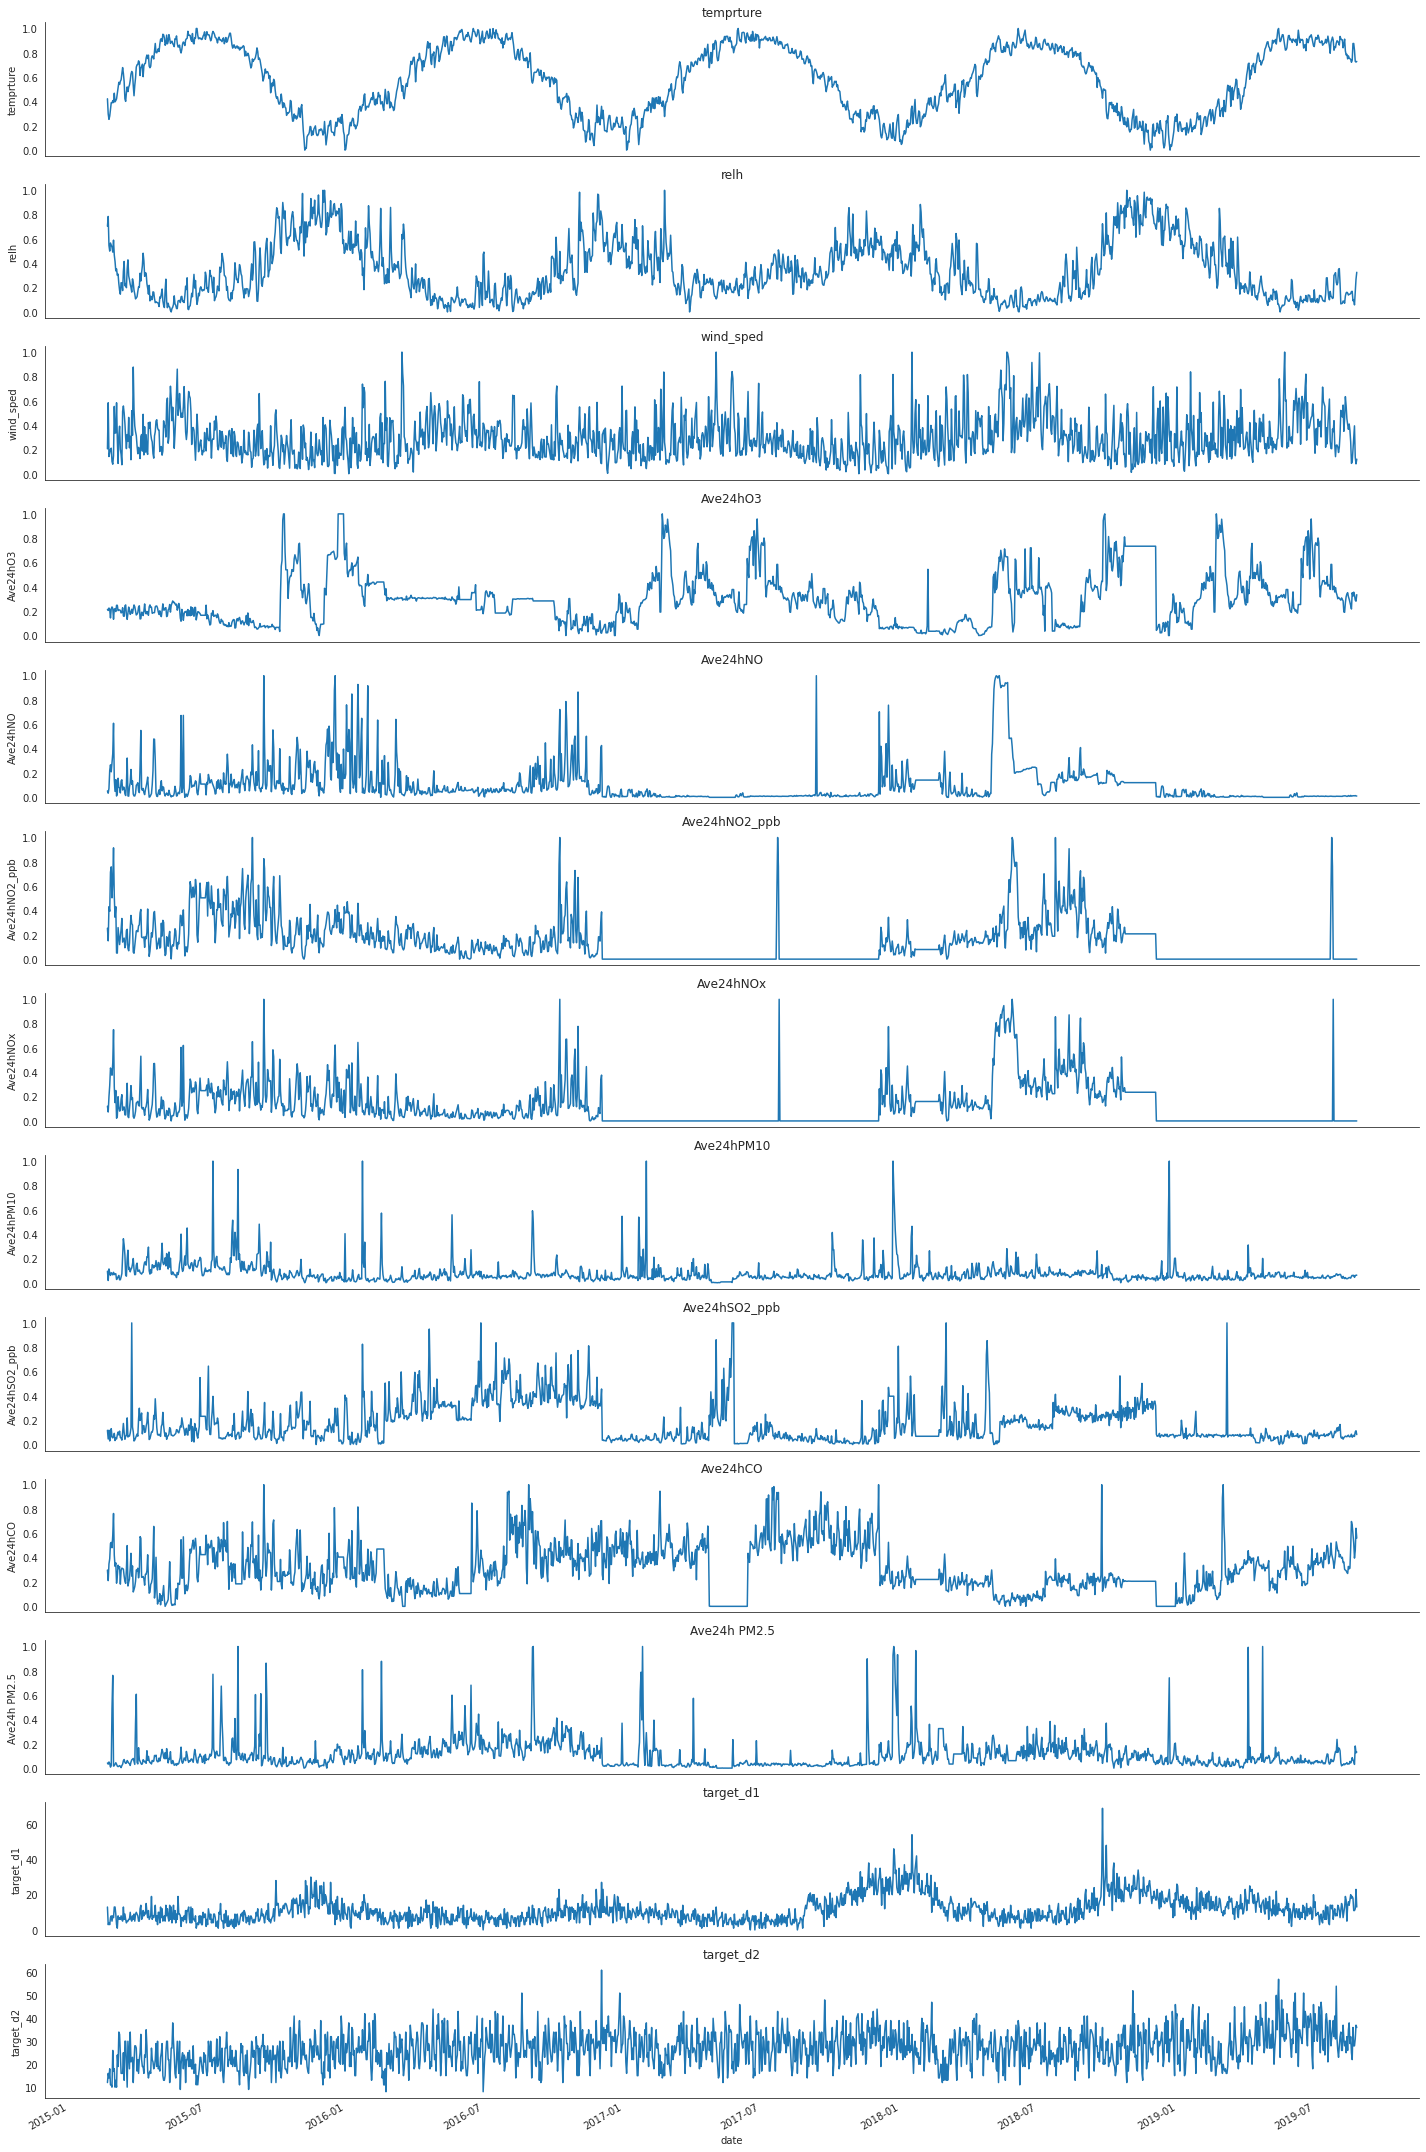

In [7]:
# Plot line charts
df_plot = df.copy()

ncols = 1
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(20, 30))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.title.set_text(df_plot.columns[i])
fig.tight_layout()
plt.show()

# Step #3 Preprocessing and Feature Selection

In [8]:
# Indexing Batches
df_train_d1 = df.copy()
df_train_d2 = df.copy()
df_train_d1.tail(5)

,temprture,relh,wind_sped,Ave24hO3,Ave24hNO,Ave24hNO2_ppb,Ave24hNOx,Ave24hPM10,Ave24hSO2_ppb,Ave24hCO,Ave24h PM2.5,target_d1,target_d2
date,,,,,,,,,,,,,
2019-09-18,0.876846,0.101150,0.288551,0.356649,0.013297,1.370084e-19,3.748783e-19,0.061326,0.076510,0.519356,0.057478,11.0,28.0
2019-09-19,0.821484,0.058007,0.393665,0.334670,0.012565,9.959760e-20,2.942348e-19,0.044351,0.066930,0.396550,0.030632,11.0,28.0
2019-09-20,0.729484,0.168947,0.135635,0.291338,0.014356,1.000925e-19,3.240762e-19,0.056560,0.103064,0.457525,0.182056,12.0,31.0
2019-09-21,0.724039,0.268493,0.081215,0.282320,0.011502,9.649457e-20,2.815784e-19,0.062459,0.113276,0.641795,0.126252,23.0,37.0
2019-09-22,0.729321,0.326031,0.119542,0.335764,0.010802,8.855843e-20,2.525517e-19,0.062165,0.081802,0.561066,0.132410,13.0,36.0


In [9]:
df_train_d1.columns

Index(['temprture', 'relh', 'wind_sped', 'Ave24hO3', 'Ave24hNO',
       'Ave24hNO2_ppb', 'Ave24hNOx', 'Ave24hPM10', 'Ave24hSO2_ppb', 'Ave24hCO',
       'Ave24h PM2.5', 'target_d1', 'target_d2'],
      dtype='object')

In [10]:
def prepare_data(df):

    # List of considered Features
    FEATURES = ['temprture', 'relh', 'wind_sped', 'Ave24hO3', 'Ave24hNO',
       'Ave24hNO2_ppb', 'Ave24hNOx', 'Ave24hPM10', 'Ave24hSO2_ppb', 'Ave24hCO',
       'Ave24h PM2.5', 'target_d1', 'target_d2']

    print('FEATURE LIST')
    print([f for f in FEATURES])

    # Create the dataset with features and filter the data to the list of FEATURES
    df_filter = df[FEATURES]
    
    # Convert the data to numpy values
    np_filter_unscaled = np.array(df_filter)
    #np_filter_unscaled = np.reshape(np_unscaled, (df_filter.shape[0], -1))
    print(np_filter_unscaled.shape)

    np_c_unscaled = np.array(df['target_d1']).reshape(-1, 1)
    
    return np_filter_unscaled, np_c_unscaled, df_filter
    
np_filter_unscaled, np_c_unscaled, df_filter = prepare_data(df_train_d1)
                                          
# Creating a separate scaler that works on a single column for scaling predictions
# Scale each feature to a range between 0 and 1
scaler_train = MinMaxScaler()
np_scaled = scaler_train.fit_transform(np_filter_unscaled)
    
# Create a separate scaler for a single column
scaler_pred = MinMaxScaler()
np_scaled_c = scaler_pred.fit_transform(np_c_unscaled)   

FEATURE LIST
['temprture', 'relh', 'wind_sped', 'Ave24hO3', 'Ave24hNO', 'Ave24hNO2_ppb', 'Ave24hNOx', 'Ave24hPM10', 'Ave24hSO2_ppb', 'Ave24hCO', 'Ave24h PM2.5', 'target_d1', 'target_d2']
(1647, 13)


In [11]:
df_train_d1.head()

,temprture,relh,wind_sped,Ave24hO3,Ave24hNO,Ave24hNO2_ppb,Ave24hNOx,Ave24hPM10,Ave24hSO2_ppb,Ave24hCO,Ave24h PM2.5,target_d1,target_d2
date,,,,,,,,,,,,,
2015-03-21,0.422193,0.705090,0.204558,0.215088,0.052561,0.254035,0.120980,0.094944,0.116997,0.298165,0.042088,13.0,12.0
2015-03-22,0.297337,0.784966,0.583254,0.206259,0.034000,0.150526,0.073354,0.018406,0.045770,0.211482,0.032855,3.0,16.0
2015-03-23,0.252944,0.545862,0.141443,0.225935,0.073821,0.430877,0.198740,0.113383,0.117710,0.348533,0.050736,4.0,14.0
2015-03-24,0.279996,0.499940,0.174661,0.213827,0.221294,0.392982,0.291659,0.079880,0.029606,0.390849,0.036994,3.0,18.0
2015-03-25,0.336875,0.566606,0.201237,0.145018,0.267021,0.715088,0.435217,0.060196,0.060307,0.516847,0.008432,7.0,11.0


(1297, 15, 13) (1297, 6)
(323, 15, 13) (323, 6)


<function matplotlib.pyplot.show(*args, **kw)>

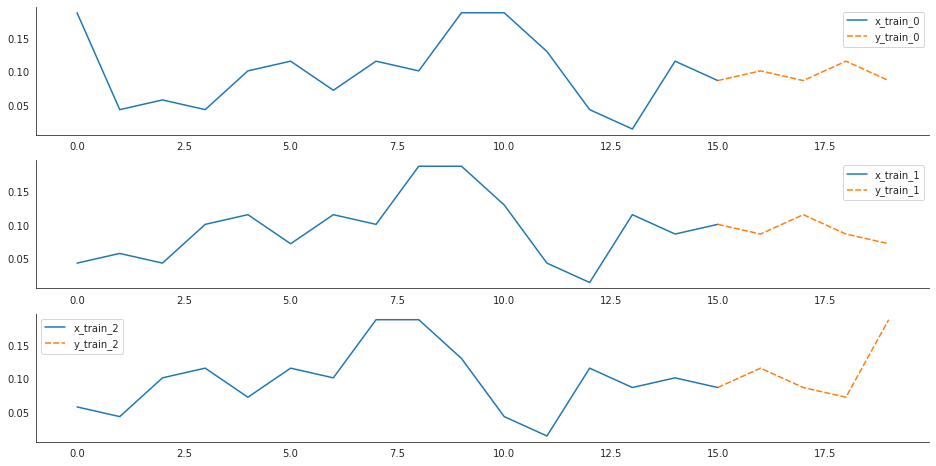

In [12]:
# Set the input_sequence_length length - this is the timeframe used to make a single prediction
input_sequence_length = 15
# The output sequence length is the number of steps that the neural network predicts
output_sequence_length = 6 #

# Prediction Index
index_Close = df_filter.columns.get_loc("target_d1")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_length = math.ceil(np_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_scaled[:train_data_length, :]
test_data = np_scaled[train_data_length - input_sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, input_sequence_length time steps per sample, and f features
def partition_dataset(input_sequence_length, output_sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(input_sequence_length, data_len - output_sequence_length):
        x.append(data[i-input_sequence_length:i,:]) #contains input_sequence_length values 0-input_sequence_length * columns
        y.append(data[i:i + output_sequence_length, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(input_sequence_length, output_sequence_length, train_data)
x_test, y_test = partition_dataset(input_sequence_length, output_sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
nrows = 3 # number of shifted plots
fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(16, 8))
for i, ax in enumerate(fig.axes):
    xtrain = pd.DataFrame(x_train[i][:,index_Close], columns={f'x_train_{i}'})
    ytrain = pd.DataFrame(y_train[i][:output_sequence_length-1], columns={f'y_train_{i}'})
    ytrain.index = np.arange(input_sequence_length, input_sequence_length + output_sequence_length-1)
    xtrain_ = pd.concat([xtrain, ytrain[:1].rename(columns={ytrain.columns[0]:xtrain.columns[0]})])
    df_merge = pd.concat([xtrain_, ytrain])
    sns.lineplot(data = df_merge, ax=ax)
plt.show

# Step #4 Model Training

In [13]:
# Configure the neural network model
model = Sequential()
n_output_neurons = output_sequence_length

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_input_neurons = x_train.shape[1] * x_train.shape[2]
print(n_input_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_input_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_input_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(n_output_neurons))

# Compile the model
model.compile(optimizer='adam', loss='mse')

195 15 13


In [14]:
# Training the model
epochs = 15
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/15
82/82 [==============================] - 10s 18ms/step - loss: 0.0073 - val_loss: 0.0061
Epoch 2/15
82/82 [==============================] - 1s 9ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 3/15
82/82 [==============================] - 1s 9ms/step - loss: 0.0048 - val_loss: 0.0053
Epoch 4/15
82/82 [==============================] - 1s 9ms/step - loss: 0.0045 - val_loss: 0.0053
Epoch 5/15
82/82 [==============================] - 1s 9ms/step - loss: 0.0045 - val_loss: 0.0052
Epoch 6/15
82/82 [==============================] - 1s 9ms/step - loss: 0.0044 - val_loss: 0.0059
Epoch 7/15
82/82 [==============================] - 1s 9ms/step - loss: 0.0044 - val_loss: 0.0199
Epoch 8/15
82/82 [==============================] - 1s 10ms/step - loss: 0.0046 - val_loss: 0.0056
Epoch 9/15
82/82 [==============================] - 1s 12ms/step - loss: 0.0042 - val_loss: 0.0068
Epoch 10/15
82/82 [==============================] - 1s 9ms/step - loss: 0.0042 - val_loss: 0.0094
Epoch 11/15
82/

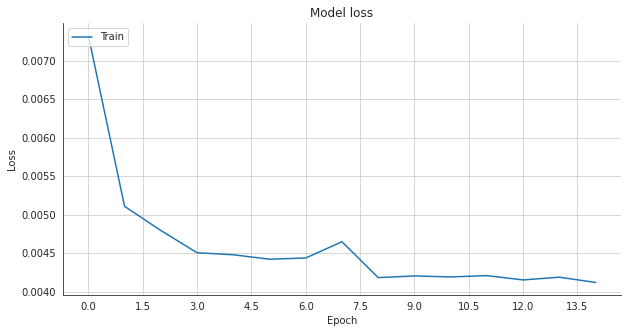

In [15]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train"], loc="upper left")
plt.grid()
plt.show()

# Step #5 Evaluate Model Performance

11/11 [==============================] - 0s 3ms/step
Median Absolute Error (MAE): 4.51
Mean Absolute Percentage Error (MAPE): 32.24 %
Median Absolute Percentage Error (MDAPE): 27.14 %


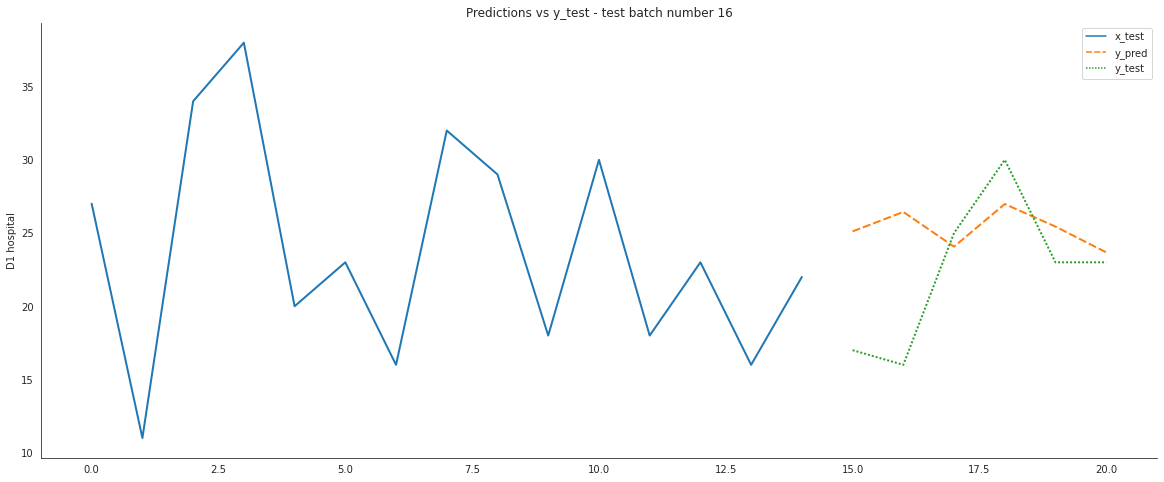

In [27]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test).reshape(-1, output_sequence_length)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')


def prepare_df(i, x, y, y_pred_unscaled):
    # Undo the scaling on x, reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform((x[i]))[:,index_Close]).rename(columns={0:'x_test'})
    
    y_test_unscaled_df = []
    # Undo the scaling on y
    if type(y) == np.ndarray:
        y_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform(y)[i]).rename(columns={0:'y_test'})

    # Create a dataframe for the y_pred at position i, y_pred is already unscaled
    y_pred_df = pd.DataFrame(y_pred_unscaled[i]).rename(columns={0:'y_pred'})
    return x_test_unscaled_df, y_pred_df, y_test_unscaled_df


def plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title): 
    # Package y_pred_unscaled and y_test_unscaled into a dataframe with columns pred and true   
    if type(y_test_unscaled_df) == pd.core.frame.DataFrame:
        df_merge = y_pred_df.join(y_test_unscaled_df, how='left')
    else:
        df_merge = y_pred_df.copy()
    
    # Merge the dataframes 
    df_merge_ = pd.concat([x_test_unscaled_df, df_merge]).reset_index(drop=True)
    
    # Plot the linecharts
    fig, ax = plt.subplots(figsize=(20, 8))
    plt.title(title, fontsize=12)
    ax.set(ylabel = "D1 hospital")
    sns.lineplot(data = df_merge_, linewidth=2.0, ax=ax)
# Creates a linechart for a specific test batch_number and corresponding test predictions
batch_number = 16
x_test_unscaled_df, y_pred_df, y_test_unscaled_df = prepare_df(20, x_test, y_test, y_pred)
title = f"Predictions vs y_test - test batch number {batch_number}"
plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title) 